In [1]:
# imports
import pandas as pd
import numpy as np

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Config matplotlib
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # in matplotlib, edge borders are turned off by default.
sns.set_style("darkgrid") # set a grey grid as a background

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

import csv
import json
import datetime as datetime
import time

# ip/AS lookup tools
import socket
from ipwhois import IPWhois
from ipwhois.net import Net
from ipwhois.asn import IPASN

### load data

In [2]:
dfbeacons = pd.read_csv('2020-tank.beacons-scrubbed.csv')
dfconns = pd.read_csv('2020-tank.conns-scrubbed.csv')
#dfdns = pd.read_csv('dns.csv')

In [3]:
dfbeacons.head()

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion
0,0.870,71.212.150.232,10.4.86.55,47329,2170.0,300,14711272,15,574,27512,27324,0.0,0.0,0,0
1,0.861,174.21.76.74,10.4.86.55,35304,1348.0,299,3398356,15,522,26333,26070,0.0,0.0,0,0
2,0.845,52.84.150.39,10.4.86.55,14104,12.0,8532,48,1,0,3963,10575,0.0,0.0,0,0
3,0.840,10.4.86.55,71.212.150.232,14357,0.0,1113,0,300,0,1783,14357,0.0,0.0,1,0
4,0.838,10.4.86.55,174.21.76.74,12162,43.0,400,84,300,0,898,7092,0.0,0.0,1,0


In [4]:
dfconns.head()

,Source IP,Destination IP,Port:Protocol:Service,Duration
0,71.212.150.232,10.4.86.55,52456:tcp:- 52454:tcp:- 52452:tcp:- 37696:tcp:...,425655.0
1,174.21.76.74,10.4.86.55,50154:tcp:- 50150:tcp:- 35430:tcp:- 35428:tcp:...,169166.0
2,174.21.155.169,10.4.86.55,36022:tcp:- 36020:tcp:- 36018:tcp:- 36014:tcp:...,104601.0
3,10.4.86.55,112.85.42.102,3:icmp:-,81888.7
4,174.21.138.33,10.4.86.55,60398:tcp:- 60396:tcp:- 60394:tcp:- 53:tcp:dns...,50334.1


### merge 

In [5]:
dfconns['ConnString'] = dfconns['Source IP'] + '->' + dfconns['Destination IP']

In [6]:
dfbeacons['ConnString'] = dfbeacons['Source IP'] + '->'+ dfbeacons['Destination IP']

In [7]:
df = pd.merge(dfbeacons, dfconns, on=['ConnString'], how='inner')

### clean up merge data

since the merge key is an amagalm of connection to connection strings, the Source IP and Destination IP collision columns _x and _y should be erroneous.

**delete _ys and rename _x**

In [8]:
del df['Source IP_y']

In [9]:
del df['Destination IP_y']

In [10]:
df.rename(columns={"Destination IP_x": "Destination IP",'Source IP_x':'Source IP'}, inplace=True)

In [11]:
df.columns

Index(['Score', 'Source IP', 'Destination IP', 'Connections', 'Avg Bytes',
       'Intvl Range', 'Size Range', 'Top Intvl', 'Top Size', 'Top Intvl Count',
       'Top Size Count', 'Intvl Skew', 'Size Skew', 'Intvl Dispersion',
       'Size Dispersion', 'ConnString', 'Port:Protocol:Service', 'Duration'],
      dtype='object')

### adding hostname lookups

In [12]:
def iplookup(ipaddress):
    #print(ipaddress)
    try: 
        fullhostname = socket.gethostbyaddr(ipaddress)
        hostname = fullhostname[0]
    except Exception as e:
        hostname = ipaddress
    return hostname

In [13]:
df['Source Name'] = df['Source IP'].apply(iplookup)

In [14]:
# this takes awhile thanks to DNS timeouts
df['Destination Name'] = df['Destination IP'].apply(iplookup)

In [15]:
df.head()

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name
0,0.870,71.212.150.232,10.4.86.55,47329,2170.0,300,14711272,15,574,27512,27324,0.0,0.0,0,0,71.212.150.232->10.4.86.55,52456:tcp:- 52454:tcp:- 52452:tcp:- 37696:tcp:...,425655.000,71-212-150-232.tukw.qwest.net,mainhost
1,0.861,174.21.76.74,10.4.86.55,35304,1348.0,299,3398356,15,522,26333,26070,0.0,0.0,0,0,174.21.76.74->10.4.86.55,50154:tcp:- 50150:tcp:- 35430:tcp:- 35428:tcp:...,169166.000,174-21-76-74.tukw.qwest.net,mainhost
2,0.833,174.21.154.117,10.4.86.55,728,1571.0,7237,270414,15,522,620,604,0.0,0.0,0,0,174.21.154.117->10.4.86.55,22:tcp:- 9180:tcp:- 9119:tcp:- 9117:tcp:- 9100...,9300.070,174-21-154-117.tukw.qwest.net,mainhost
3,0.828,10.4.86.55,139.59.38.252,141,133.0,138,2120,65,88,30,138,0.0,0.0,1,0,10.4.86.55->139.59.38.252,3:icmp:-,133.375,mainhost,139.59.38.252
4,0.827,10.4.86.55,189.62.69.106,94,397.0,44573,1856,76,352,34,88,0.0,0.0,1,0,10.4.86.55->189.62.69.106,3:icmp:-,161.082,mainhost,bd3e456a.virtua.com.br


### Describing the IP sets

In [16]:
# unique localhosts
len(df['Source IP'].unique())

56

In [17]:
df['Source IP'].unique()

array(['71.212.150.232', '174.21.76.74', '174.21.154.117', '10.4.86.55',
       '193.112.19.133', '223.247.137.208', '222.186.42.7',
       '222.186.42.57', '222.186.42.213', '174.21.155.169',
       '123.206.65.38', '71.212.135.10', '118.89.245.202', '10.0.1.50',
       '106.52.152.237', '106.53.114.90', '122.51.22.134', '174.21.134.5',
       '49.233.32.245', '129.28.27.25', '122.194.229.59',
       '61.177.172.107', '61.177.172.128', '218.92.0.172', '85.209.0.102',
       '129.204.125.51', '117.211.192.70', '118.24.117.134',
       '166.78.71.156', '129.204.100.10', '49.232.191.178',
       '112.85.42.174', '94.191.62.195', '174.21.138.33',
       '194.180.224.130', '85.209.0.103', '189.62.69.106', '166.78.68.80',
       '139.186.68.53', '85.209.0.253', '122.51.221.184', '119.45.205.97',
       '85.209.0.251', '122.51.10.222', '119.45.137.52',
       '111.231.215.244', '49.232.162.77', '222.186.180.147',
       '102.37.12.59', '42.194.203.226', '159.135.232.78',
       '146.20.191.2

In [18]:
# unique targets
len(df['Destination IP'].unique())

662

In [19]:
# unique connections
len(df['ConnString'].unique())

715

### update AS info

In [20]:
newcols = ['asn_registry', 'asn', 'asn_cidr', 'asn_country_code', 'asn_date', 'asn_description']

In [21]:
def getAsInfo(ipaddress, category='asn', **kwargs):
    """
    df['Destination IP'].apply(getAsInfoKwargs, category='asncidr',axis=1)
    """
    private = ['10.','172.','192.168.']
    if '10.4' in ipaddress:
        return 'rfc1918'
    #print(kwargs)
    net = Net(ipaddress)
    obj = IPASN(net)
    results = obj.lookup()
    if category is None:
        return "no category"
        #print(category)
    
    if category == 'reg':
        return results['asn_registry']
    elif category == 'asnnum':
        return results['asn']
    elif category == 'asncidr':
        return results['asn_cidr']
    elif category == 'asncc':
        return results['asn_country_code']
    elif category == 'asndate':
        return results['asn_date']
    elif category == 'asndesc':
        return results['asn_description']
    else:
        return False
    

In [22]:
# add asncidr
df['asncidr'] = df['Destination IP'].apply(getAsInfo, category='asncidr',axis=1)

In [23]:
df['asn'] = df['Destination IP'].apply(getAsInfo, category='asnnum',axis=1)

In [24]:
df['asn_desc'] = df['Destination IP'].apply(getAsInfo, category='asndesc',axis=1)

In [25]:
df['asn_country'] = df['Destination IP'].apply(getAsInfo, category='asncc',axis=1)

In [26]:
df['asn'].unique()

array(['rfc1918', '14061', '28573', '45090', '7713', '58224', '131367',
       '16276', '3462', '4812', '56046', '4837', '18403', '38457',
       '132637', '38365', '4808 23724', '52440', '265032', '49816',
       '9808', '132203', '14259', '3352', '28006', '9829', '7506',
       '10481', '38442', '139190', '133115', '14868', '2711', '24444',
       '4766', '56041', '4808', '24560', '15169', '12876', '134762',
       '8075', '132435', '4134', '36352', '8167', '3786', '134238',
       '264294', '10620', '31483', '8193', '701', '4788', '135377',
       '33576', '140443', '9121', '4847', '28506', '262545', '132199',
       '9370', '577', '3449', '135003', '17222', '23650', '9335', '9498',
       '37352', '269805', '9318', '17451', '25820', '14117', '20746',
       '4760', '10226', '23724', '137443', '56150', '4270', '49505',
       '45595', '25620', '16814', '17727', '24173', '56158', '9541',
       '2518', '262591', '3549', '58461', '16735', '14080', '265741',
       '37006', '8151', '20

In [27]:
# weird entry - whois returns the AS info, but no description or prefix
# AS      | IP               | BGP Prefix          | CC | Registry | Allocated  | AS Name
# NA      | 69.195.171.128   | NA                  | US | arin     | 2017-09-18 | NA
# From Hurricane Electric - Twitter:
# AS13414 IRR Valid 69.195.171.0/24 Twitter Inc.
df[df['asn'] == 'NA']

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
596,0.686,10.4.86.55,87.251.74.36,25,422.0,7576,3372,3753,88,2,...,0,10.4.86.55->87.251.74.36,3:icmp:-,193.596,mainhost,prevarication.xyz,NA,NA,NA,RU


In [28]:
df['asn'].unique()

array(['rfc1918', '14061', '28573', '45090', '7713', '58224', '131367',
       '16276', '3462', '4812', '56046', '4837', '18403', '38457',
       '132637', '38365', '4808 23724', '52440', '265032', '49816',
       '9808', '132203', '14259', '3352', '28006', '9829', '7506',
       '10481', '38442', '139190', '133115', '14868', '2711', '24444',
       '4766', '56041', '4808', '24560', '15169', '12876', '134762',
       '8075', '132435', '4134', '36352', '8167', '3786', '134238',
       '264294', '10620', '31483', '8193', '701', '4788', '135377',
       '33576', '140443', '9121', '4847', '28506', '262545', '132199',
       '9370', '577', '3449', '135003', '17222', '23650', '9335', '9498',
       '37352', '269805', '9318', '17451', '25820', '14117', '20746',
       '4760', '10226', '23724', '137443', '56150', '4270', '49505',
       '45595', '25620', '16814', '17727', '24173', '56158', '9541',
       '2518', '262591', '3549', '58461', '16735', '14080', '265741',
       '37006', '8151', '20

**what AS regions get the most traffic?**

In [29]:
df[['asn','asn_desc','Source IP']].value_counts()

asn    asn_desc                                                                    Source IP 
45090  CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN  10.4.86.55    190
14061  DIGITALOCEAN-ASN, US                                                        10.4.86.55     62
4134   CHINANET-BACKBONE No.31,Jin-rong Street, CN                                 10.4.86.55     24
4837   CHINA169-BACKBONE CHINA UNICOM China169 Backbone, CN                        10.4.86.55     21
16276  OVH, FR                                                                     10.4.86.55     20
                                                                                                ... 
59019  BJKSCNET Beijing Kingsoft Cloud Internet Technology Co., Ltd, CN            10.4.86.55      1
58466  CT-GUANGZHOU-IDC CHINANET Guangdong province network, CN                    10.4.86.55      1
58461  CT-HANGZHOU-IDC No.288,Fu-chun Road, CN                                     10.4.86.55     

In [30]:
df[['asn','asn_desc','Source IP']][:11].value_counts()

asn      asn_desc                                                                    Source IP     
45090    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN  10.4.86.55        3
14061    DIGITALOCEAN-ASN, US                                                        10.4.86.55        2
rfc1918  rfc1918                                                                     71.212.150.232    1
                                                                                     174.21.76.74      1
                                                                                     174.21.154.117    1
7713     TELKOMNET-AS-AP PT Telekomunikasi Indonesia, ID                             10.4.86.55        1
58224    TCI, IR                                                                     10.4.86.55        1
28573    CLARO S.A., BR                                                              10.4.86.55        1
dtype: int64

### Stats analysis

In [31]:
df['Score'].mean()

0.7295916083916084

In [32]:
df['Duration'].mean()

1309.0004447552446

In [33]:
df.corr()

,Score,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion,Duration
Score,1.000000,0.026465,-0.081054,-0.448817,-0.041615,0.007289,-0.235251,0.057611,0.040706,-0.175607,-0.391367,-0.224669,-0.542083,0.035617
Connections,0.026465,1.000000,0.115444,0.011322,0.120214,-0.047379,0.159794,0.951344,0.992811,0.007788,0.014473,-0.008886,-0.006612,0.907589
Avg Bytes,-0.081054,0.115444,1.000000,0.002633,0.943091,-0.031075,0.032276,0.025803,0.094607,-0.033380,0.062408,0.006087,0.022313,0.234934
Intvl Range,-0.448817,0.011322,0.002633,1.000000,-0.012754,-0.057066,0.151054,-0.010371,0.006886,0.106810,0.219643,0.056562,0.266307,-0.019095
Size Range,-0.041615,0.120214,0.943091,-0.012754,1.000000,-0.023970,-0.001492,0.026694,0.099320,-0.029580,0.030949,0.002080,-0.003005,0.246188
Top Intvl,0.007289,-0.047379,-0.031075,-0.057066,-0.023970,1.000000,0.034993,-0.037547,-0.046859,-0.006542,-0.051958,0.317770,-0.050137,-0.036683
Top Size,-0.235251,0.159794,0.032276,0.151054,-0.001492,0.034993,1.000000,0.186222,0.162924,0.113465,0.103187,0.280744,0.251504,0.172447
Top Intvl Count,0.057611,0.951344,0.025803,-0.010371,0.026694,-0.037547,0.186222,1.000000,0.965016,-0.008890,-0.000543,-0.009414,-0.009107,0.896038
Top Size Count,0.040706,0.992811,0.094607,0.006886,0.099320,-0.046859,0.162924,0.965016,1.000000,0.005942,0.004621,-0.009879,-0.013537,0.873717
Intvl Skew,-0.175607,0.007788,-0.033380,0.106810,-0.029580,-0.006542,0.113465,-0.008890,0.005942,1.000000,0.170375,0.087717,0.094597,-0.038729


### adding viz and stats

<AxesSubplot:>

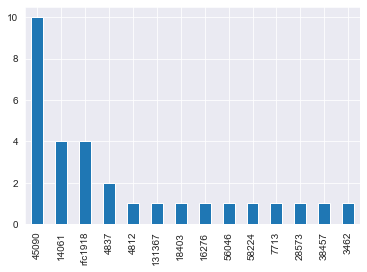

In [34]:
df['asn'][:30].value_counts().plot(kind='bar')

<AxesSubplot:>

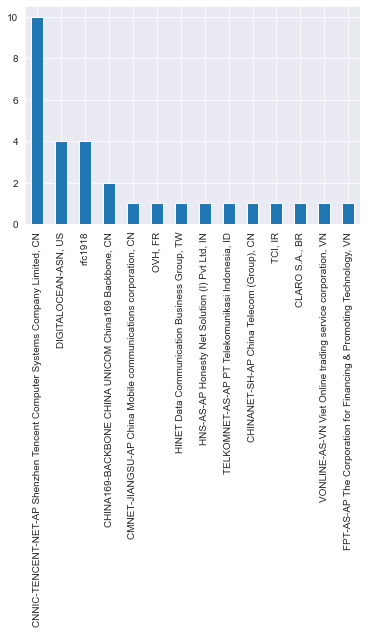

In [35]:
df['asn_desc'][:30].value_counts().plot(kind='bar')

<AxesSubplot:>

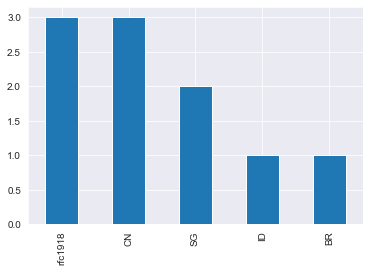

In [36]:
df['asn_country'][:10].value_counts().plot(kind='bar')

<AxesSubplot:>

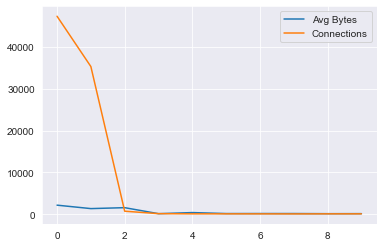

In [37]:
df[['Avg Bytes','Connections']][:10].plot()

<AxesSubplot:>

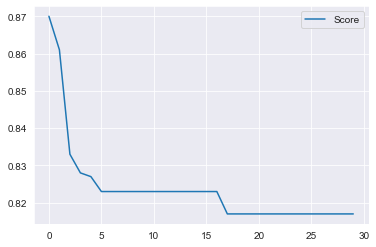

In [38]:
df[['Score']][:30].plot(y='Score')

**whats the relative occurrance of high beacon traffic?**

<AxesSubplot:xlabel='Score'>

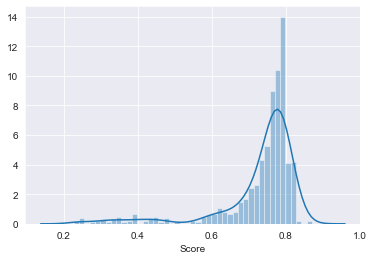

In [39]:
sns.distplot(df['Score'])

**how about long duration**

<AxesSubplot:xlabel='Duration'>

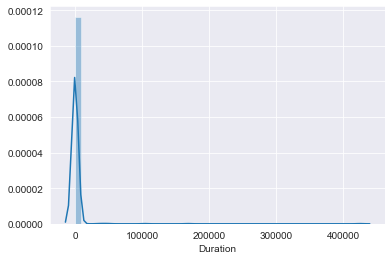

In [40]:
sns.distplot(df['Duration'])

**heatmap broken for now**

In [41]:
# Erroring on:
#TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
# sns.heatmap(df)

### High Beaconish Originators

In [42]:
df[(df['Score'] >.80)][3:]['asn_desc']

3                                  DIGITALOCEAN-ASN, US
4                                        CLARO S.A., BR
5     CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
6     CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
7                                  DIGITALOCEAN-ASN, US
                            ...                        
78    CHINA169-BJ China Unicom Beijing Province Netw...
79    TENCENT-NET-AP-CN Tencent Building, Kejizhongy...
80    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
81    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
82    AIRTELBROADBAND-AS-AP Bharti Airtel Ltd., Tele...
Name: asn_desc, Length: 80, dtype: object

In [43]:
df['asn_country'].value_counts()

CN         336
US          75
rfc1918     54
BR          26
KR          25
IN          20
CA          17
VN          16
ID          14
SG          13
AR          13
FR          11
GB          10
CO           6
JP           5
TH           5
TW           5
MY           5
RU           5
BD           4
IR           4
PK           3
CL           3
TR           3
HK           3
MX           2
AE           2
PH           2
LT           2
SC           2
ZA           2
EC           2
CR           2
VE           1
IT           1
PY           1
ZW           1
UY           1
JM           1
UG           1
ES           1
UZ           1
BO           1
BF           1
MA           1
KZ           1
LA           1
FJ           1
MU           1
HR           1
BG           1
Name: asn_country, dtype: int64

In [44]:
# highest traffic country entries
df[df['asn_country'] =='CN']

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
5,0.823,10.4.86.55,62.234.15.136,92,163.0,185,2224,89,88,13,...,0,10.4.86.55->62.234.15.136,3:icmp:-,177.767,mainhost,62.234.15.136,62.234.0.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
6,0.823,10.4.86.55,106.54.112.173,89,169.0,268,2472,87,88,15,...,0,10.4.86.55->106.54.112.173,3:icmp:-,259.984,mainhost,106.54.112.173,106.54.64.0/18,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
9,0.823,10.4.86.55,122.51.147.181,93,145.0,155,2064,74,88,16,...,0,10.4.86.55->122.51.147.181,3:icmp:-,154.728,mainhost,122.51.147.181,122.51.128.0/18,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
12,0.823,10.4.86.55,119.45.199.173,39,168.0,255,2076,230,88,8,...,0,10.4.86.55->119.45.199.173,3:icmp:-,116.138,mainhost,119.45.199.173,119.45.192.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
13,0.823,10.4.86.55,49.234.67.158,30,147.0,296,1772,285,88,4,...,0,10.4.86.55->49.234.67.158,3:icmp:-,118.678,mainhost,49.234.67.158,49.234.64.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,0.442,10.4.86.55,222.186.31.166,76,469.0,146121,2388,980,264,2,...,88,10.4.86.55->222.186.31.166,3:icmp:-,116.738,mainhost,222.186.31.166,222.186.31.0/24,23650,CHINANET-JIANGSU-PROVINCE-IDC AS Number for CH...,CN
678,0.441,10.4.86.55,222.186.30.57,88,367.0,112922,2512,675,264,1,...,88,10.4.86.55->222.186.30.57,3:icmp:-,168.555,mainhost,222.186.30.57,222.186.30.0/24,23650,CHINANET-JIANGSU-PROVINCE-IDC AS Number for CH...,CN
679,0.432,10.4.86.55,222.186.31.83,72,384.0,103369,2516,1089,264,2,...,88,10.4.86.55->222.186.31.83,3:icmp:-,115.943,mainhost,222.186.31.83,222.186.31.0/24,23650,CHINANET-JIANGSU-PROVINCE-IDC AS Number for CH...,CN
680,0.432,10.4.86.55,218.92.0.204,185,3258.0,2026,14080,408,528,4,...,1408,10.4.86.55->218.92.0.204,3:icmp:-,2009.650,mainhost,218.92.0.204,218.92.0.0/16,4134,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",CN


### build a view of connections where duration value is short and beaconish is high

In [45]:
# What are the relative duration statistics?
df['Duration'].describe()

count       715.000000
mean       1309.000445
std       17764.105103
min         115.132000
25%         116.858500
50%         117.486000
75%         139.343000
max      425655.000000
Name: Duration, dtype: float64

In [46]:
# What is the relative score distribution?
df['Score'].describe()

count    715.000000
mean       0.729592
std        0.110882
min        0.227000
25%        0.723000
50%        0.766000
75%        0.788000
max        0.870000
Name: Score, dtype: float64

In [47]:
# looking at raw duration length values
df['Duration'].sort_values()

648       115.132
712       115.144
498       115.191
362       115.191
520       115.194
          ...    
615     43213.400
691     50334.100
609    104601.000
1      169166.000
0      425655.000
Name: Duration, Length: 715, dtype: float64

**Start drilling down**

In [48]:
# 
df['Duration'].mean()

1309.0004447552446

In [49]:
# Show only durations below the mean
df[df['Duration'] < df['Duration'].mean()]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
3,0.828,10.4.86.55,139.59.38.252,141,133.0,138,2120,65,88,30,...,0,10.4.86.55->139.59.38.252,3:icmp:-,133.375,mainhost,139.59.38.252,139.59.32.0/20,14061,"DIGITALOCEAN-ASN, US",SG
4,0.827,10.4.86.55,189.62.69.106,94,397.0,44573,1856,76,352,34,...,0,10.4.86.55->189.62.69.106,3:icmp:-,161.082,mainhost,bd3e456a.virtua.com.br,189.62.0.0/16,28573,"CLARO S.A., BR",BR
5,0.823,10.4.86.55,62.234.15.136,92,163.0,185,2224,89,88,13,...,0,10.4.86.55->62.234.15.136,3:icmp:-,177.767,mainhost,62.234.15.136,62.234.0.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
6,0.823,10.4.86.55,106.54.112.173,89,169.0,268,2472,87,88,15,...,0,10.4.86.55->106.54.112.173,3:icmp:-,259.984,mainhost,106.54.112.173,106.54.64.0/18,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
7,0.823,10.4.86.55,139.59.70.186,77,167.0,156,2032,123,88,10,...,0,10.4.86.55->139.59.70.186,3:icmp:-,139.581,mainhost,139.59.70.186,139.59.64.0/20,14061,"DIGITALOCEAN-ASN, US",SG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,0.247,146.20.191.250,10.4.86.55,42,2365.0,1155104,22326,1,867,9,...,295,146.20.191.250->10.4.86.55,25:tcp:- 25:tcp:smtp,139.105,m250.email.mailgun.net,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
711,0.246,69.72.43.210,10.4.86.55,33,7852.0,1040164,92273,1,864,4,...,56,69.72.43.210->10.4.86.55,25:tcp:- 25:tcp:smtp,160.405,m43-210.mailgun.net,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
712,0.242,222.186.180.8,10.4.86.55,792,539.0,57496,2891,120,0,125,...,40,222.186.180.8->10.4.86.55,22:tcp:- 22:tcp:ssh,115.144,222.186.180.8,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
713,0.240,175.24.67.124,10.4.86.55,129,968.0,759087,1389,5,208,18,...,208,175.24.67.124->10.4.86.55,22:tcp:- 22:tcp:ssh,120.344,175.24.67.124,mainhost,rfc1918,rfc1918,rfc1918,rfc1918


**what are connections where duration is below a particular quantile?**

In [50]:
df[df['Duration'] < df['Duration'].quantile(.2)]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
12,0.823,10.4.86.55,119.45.199.173,39,168.0,255,2076,230,88,8,...,0,10.4.86.55->119.45.199.173,3:icmp:-,116.138,mainhost,119.45.199.173,119.45.192.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
16,0.823,10.4.86.55,45.55.242.212,47,128.0,211,1904,182,88,7,...,0,10.4.86.55->45.55.242.212,3:icmp:-,116.385,mainhost,45.55.242.212,45.55.192.0/18,14061,"DIGITALOCEAN-ASN, US",US
26,0.817,10.4.86.55,120.88.46.226,38,241.0,257,1944,236,88,5,...,0,10.4.86.55->120.88.46.226,3:icmp:-,116.170,mainhost,120-88-46-226.snat21.hns.net.in,120.88.46.0/24,38457,"HNS-AS-AP Honesty Net Solution (I) Pvt Ltd, IN",IN
28,0.817,10.4.86.55,49.235.69.80,34,239.0,506,1788,243,88,4,...,0,10.4.86.55->49.235.69.80,3:icmp:-,115.211,mainhost,49.235.69.80,49.235.64.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
31,0.817,10.4.86.55,119.45.137.52,25,291.0,581,1680,341,88,3,...,0,10.4.86.55->119.45.137.52,3:icmp:-,116.371,mainhost,119.45.137.52,119.45.128.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.500,10.4.86.55,117.211.192.70,61,302.0,301,1964,180,68,26,...,284,10.4.86.55->117.211.192.70,3:icmp:-,116.419,mainhost,117.211.192.70,117.211.192.0/20,9829,"BSNL-NIB National Internet Backbone, IN",IN
671,0.473,10.4.86.55,222.186.42.155,82,344.0,116591,2128,1291,264,2,...,88,10.4.86.55->222.186.42.155,3:icmp:-,116.373,mainhost,222.186.42.155,222.186.42.0/24,23650,CHINANET-JIANGSU-PROVINCE-IDC AS Number for CH...,CN
679,0.432,10.4.86.55,222.186.31.83,72,384.0,103369,2516,1089,264,2,...,88,10.4.86.55->222.186.31.83,3:icmp:-,115.943,mainhost,222.186.31.83,222.186.31.0/24,23650,CHINANET-JIANGSU-PROVINCE-IDC AS Number for CH...,CN
694,0.345,189.62.69.106,10.4.86.55,198,167.0,44634,1569,7,60,89,...,120,189.62.69.106->10.4.86.55,22:tcp:- 22:tcp:ssh,115.282,bd3e456a.virtua.com.br,mainhost,rfc1918,rfc1918,rfc1918,rfc1918


**connections where duration value is short and beaconish is high**

- only get low duration connections which exhibit above %75 beaconism 

In this case, there a bunch of ICMP messages originating from my host heading to (mostly) China

In [51]:
print(len(df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)]))
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)]

84


,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
12,0.823,10.4.86.55,119.45.199.173,39,168.0,255,2076,230,88,8,...,0,10.4.86.55->119.45.199.173,3:icmp:-,116.138,mainhost,119.45.199.173,119.45.192.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
16,0.823,10.4.86.55,45.55.242.212,47,128.0,211,1904,182,88,7,...,0,10.4.86.55->45.55.242.212,3:icmp:-,116.385,mainhost,45.55.242.212,45.55.192.0/18,14061,"DIGITALOCEAN-ASN, US",US
26,0.817,10.4.86.55,120.88.46.226,38,241.0,257,1944,236,88,5,...,0,10.4.86.55->120.88.46.226,3:icmp:-,116.170,mainhost,120-88-46-226.snat21.hns.net.in,120.88.46.0/24,38457,"HNS-AS-AP Honesty Net Solution (I) Pvt Ltd, IN",IN
28,0.817,10.4.86.55,49.235.69.80,34,239.0,506,1788,243,88,4,...,0,10.4.86.55->49.235.69.80,3:icmp:-,115.211,mainhost,49.235.69.80,49.235.64.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
31,0.817,10.4.86.55,119.45.137.52,25,291.0,581,1680,341,88,3,...,0,10.4.86.55->119.45.137.52,3:icmp:-,116.371,mainhost,119.45.137.52,119.45.128.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,0.756,10.4.86.55,45.158.199.156,26,228.0,398,1588,340,88,2,...,0,10.4.86.55->45.158.199.156,3:icmp:-,115.507,mainhost,45.158.199.156,45.158.199.0/24,35913,"DEDIPATH-LLC, US",PH
435,0.755,10.4.86.55,46.37.168.7,48,381.0,222,1964,202,352,7,...,0,10.4.86.55->46.37.168.7,3:icmp:-,116.354,mainhost,46.37.168.7.srvlist.ukfast.net,46.37.160.0/19,61323,"UKFAST, GB",GB
437,0.755,10.4.86.55,180.76.178.253,36,156.0,275,1944,243,88,3,...,0,10.4.86.55->180.76.178.253,3:icmp:-,116.008,mainhost,180.76.178.253,180.76.160.0/19,38365,BAIDU Beijing Baidu Netcom Science and Technol...,CN
438,0.754,10.4.86.55,43.243.75.62,26,302.0,810,2156,370,88,2,...,0,10.4.86.55->43.243.75.62,3:icmp:-,115.366,mainhost,43.243.75.62,43.243.75.0/24,38197,SUNHK-DATA-AS-AP Sun Network (Hong Kong) Limit...,HK


In [52]:
# is anything not originating from my ip?
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)]['Source IP'].unique()

array(['10.4.86.55', '223.247.137.208'], dtype=object)

In [53]:
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)&(df['Source IP'].str.contains('10.4.86.55'))]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country


In [54]:
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)&(df['Source IP'] != '10.4.86.55')]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
12,0.823,10.4.86.55,119.45.199.173,39,168.0,255,2076,230,88,8,...,0,10.4.86.55->119.45.199.173,3:icmp:-,116.138,mainhost,119.45.199.173,119.45.192.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
16,0.823,10.4.86.55,45.55.242.212,47,128.0,211,1904,182,88,7,...,0,10.4.86.55->45.55.242.212,3:icmp:-,116.385,mainhost,45.55.242.212,45.55.192.0/18,14061,"DIGITALOCEAN-ASN, US",US
26,0.817,10.4.86.55,120.88.46.226,38,241.0,257,1944,236,88,5,...,0,10.4.86.55->120.88.46.226,3:icmp:-,116.170,mainhost,120-88-46-226.snat21.hns.net.in,120.88.46.0/24,38457,"HNS-AS-AP Honesty Net Solution (I) Pvt Ltd, IN",IN
28,0.817,10.4.86.55,49.235.69.80,34,239.0,506,1788,243,88,4,...,0,10.4.86.55->49.235.69.80,3:icmp:-,115.211,mainhost,49.235.69.80,49.235.64.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
31,0.817,10.4.86.55,119.45.137.52,25,291.0,581,1680,341,88,3,...,0,10.4.86.55->119.45.137.52,3:icmp:-,116.371,mainhost,119.45.137.52,119.45.128.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,0.756,10.4.86.55,45.158.199.156,26,228.0,398,1588,340,88,2,...,0,10.4.86.55->45.158.199.156,3:icmp:-,115.507,mainhost,45.158.199.156,45.158.199.0/24,35913,"DEDIPATH-LLC, US",PH
435,0.755,10.4.86.55,46.37.168.7,48,381.0,222,1964,202,352,7,...,0,10.4.86.55->46.37.168.7,3:icmp:-,116.354,mainhost,46.37.168.7.srvlist.ukfast.net,46.37.160.0/19,61323,"UKFAST, GB",GB
437,0.755,10.4.86.55,180.76.178.253,36,156.0,275,1944,243,88,3,...,0,10.4.86.55->180.76.178.253,3:icmp:-,116.008,mainhost,180.76.178.253,180.76.160.0/19,38365,BAIDU Beijing Baidu Netcom Science and Technol...,CN
438,0.754,10.4.86.55,43.243.75.62,26,302.0,810,2156,370,88,2,...,0,10.4.86.55->43.243.75.62,3:icmp:-,115.366,mainhost,43.243.75.62,43.243.75.0/24,38197,SUNHK-DATA-AS-AP Sun Network (Hong Kong) Limit...,HK


In [55]:
def showline(ipaddress):
    return df[df['Source IP'] == ipaddress]

In [56]:
df[df['Source IP'] == '223.247.137.208']

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
260,0.784,223.247.137.208,10.4.86.55,36,347.0,503,1633,308,60,6,...,0,223.247.137.208->10.4.86.55,22:tcp:- 22:tcp:ssh,115.725,223.247.137.208,mainhost,rfc1918,rfc1918,rfc1918,rfc1918


In [57]:
# where are ssh connections coming/going?
df[(df['Port:Protocol:Service'].str.contains('ssh')) & (df['Source IP'] != "10.4.86.55")]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
17,0.817,193.112.19.133,10.4.86.55,69,228.0,288,2508,177,60,12,...,0,193.112.19.133->10.4.86.55,22:tcp:- 22:tcp:ssh,124.160,193.112.19.133,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
260,0.784,223.247.137.208,10.4.86.55,36,347.0,503,1633,308,60,6,...,0,223.247.137.208->10.4.86.55,22:tcp:- 22:tcp:ssh,115.725,223.247.137.208,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
580,0.698,222.186.42.7,10.4.86.55,2449,387.0,149244,2990,6,0,302,...,0,222.186.42.7->10.4.86.55,22:tcp:ssh 22:tcp:-,122.799,222.186.42.7,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
581,0.698,222.186.42.57,10.4.86.55,2426,345.0,97353,2658,6,0,273,...,0,222.186.42.57->10.4.86.55,22:tcp:- 22:tcp:ssh,115.307,222.186.42.57,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
606,0.678,222.186.42.213,10.4.86.55,2298,367.0,112072,3019,5,0,328,...,0,222.186.42.213->10.4.86.55,22:tcp:- 22:tcp:ssh,118.469,222.186.42.213,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
613,0.668,123.206.65.38,10.4.86.55,60,215.0,617,1653,218,60,5,...,0,123.206.65.38->10.4.86.55,22:tcp:- 22:tcp:ssh,240.912,123.206.65.38,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
625,0.645,118.89.245.202,10.4.86.55,40,339.0,452,2192,305,60,4,...,0,118.89.245.202->10.4.86.55,22:tcp:- 22:tcp:ssh,125.064,118.89.245.202,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
631,0.635,106.52.152.237,10.4.86.55,38,239.0,784,1913,314,60,3,...,0,106.52.152.237->10.4.86.55,22:tcp:- 22:tcp:ssh,117.223,106.52.152.237,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
647,0.611,106.53.114.90,10.4.86.55,42,226.0,382,1685,312,60,5,...,0,106.53.114.90->10.4.86.55,22:tcp:- 22:tcp:ssh,145.064,106.53.114.90,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
648,0.608,122.51.22.134,10.4.86.55,45,238.0,534,1848,6,60,4,...,0,122.51.22.134->10.4.86.55,22:tcp:- 22:tcp:ssh,115.132,122.51.22.134,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
